# Evaluating synthetic yeast promoters using Polygraph

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats
pd.set_option('display.precision', 2)
%matplotlib inline

2024-01-31 21:31:35.242221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read data

The input file should be a tab or comma separated file with two columns. The first column contains the sequence and the second contains the group. The `read_seqs` function will assign a unique ID to each sequence.

In [2]:
seqs = polygraph.input.read_seqs('yeast_seqs.txt')
seqs.head()

,Sequence,Group
SeqID,,
seq_0,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTCTGTACGTTA...,native_high
seq_1,CATCGACTTATTTTTTTTTTTTGATGAAATTTTTCAGATTTTACAA...,native_high
seq_2,GCCTCTTATTTTTTTTTTTTTCGATTTTTGGCCCACAGGTCATATT...,native_high
seq_3,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTGTGTACGTTA...,native_high
seq_4,AGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACA...,native_high


This dataset contains the sequences of selected native yeast promoters as well as 50 random sequences and 50 synthetic promoters each generated by evolution and gradient (Ledidi) methods starting from the random sequences.

In [3]:
print(seqs.Group.value_counts())

native_high         50
native_low          50
random              50
evolution           50
gradient            50
guided_evolution    50
Name: Group, dtype: int64


# 1. Evaluate sequence content

## 1.1 GC content

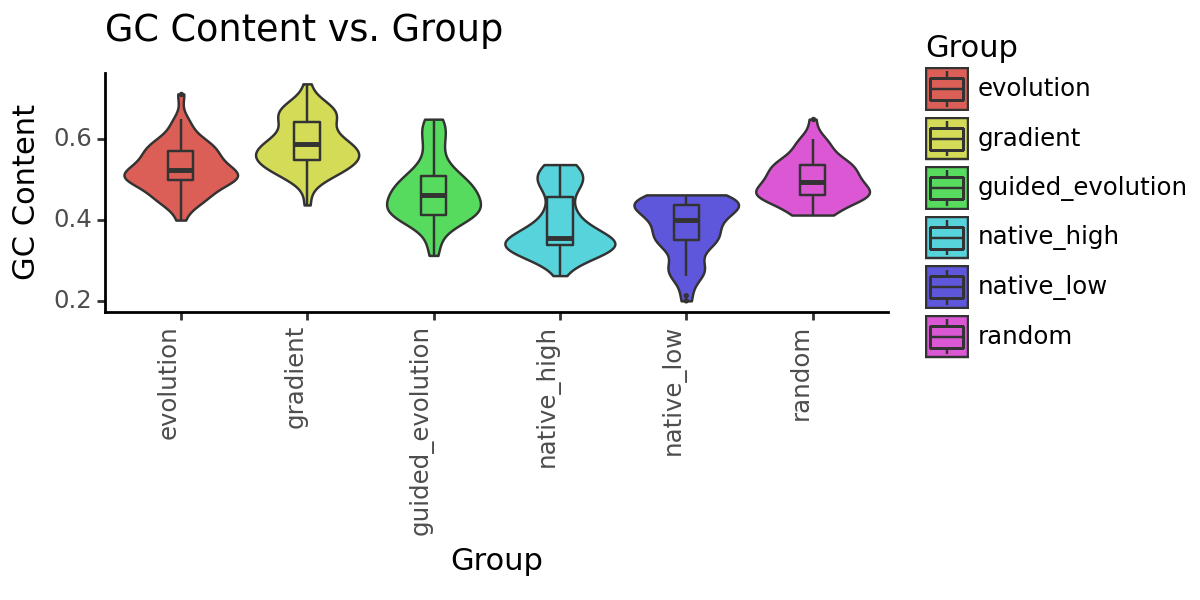

<Figure Size: (600 x 300)>

In [5]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(6,3))

In [6]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 1.0667060077212982e-34,
 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
 evolution          1.00e+00  6.59e-03          8.37e-04     2.03e-12   
 gradient           6.59e-03  1.00e+00          1.54e-09     1.09e-22   
 guided_evolution   8.37e-04  1.54e-09          1.00e+00     2.27e-04   
 native_high        2.03e-12  1.09e-22          2.27e-04     1.00e+00   
 native_low         4.47e-14  8.19e-25          2.51e-05     5.90e-01   
 random             9.51e-02  1.20e-05          9.51e-02     8.57e-08   
 
                   native_low    random  
 evolution           4.47e-14  9.51e-02  
 gradient            8.19e-25  1.20e-05  
 guided_evolution    2.51e-05  9.51e-02  
 native_high         5.90e-01  8.57e-08  
 native_low          1.00e+00  4.11e-09  
 random              4.11e-09  1.00e+00  }

## 1.2 length distribution

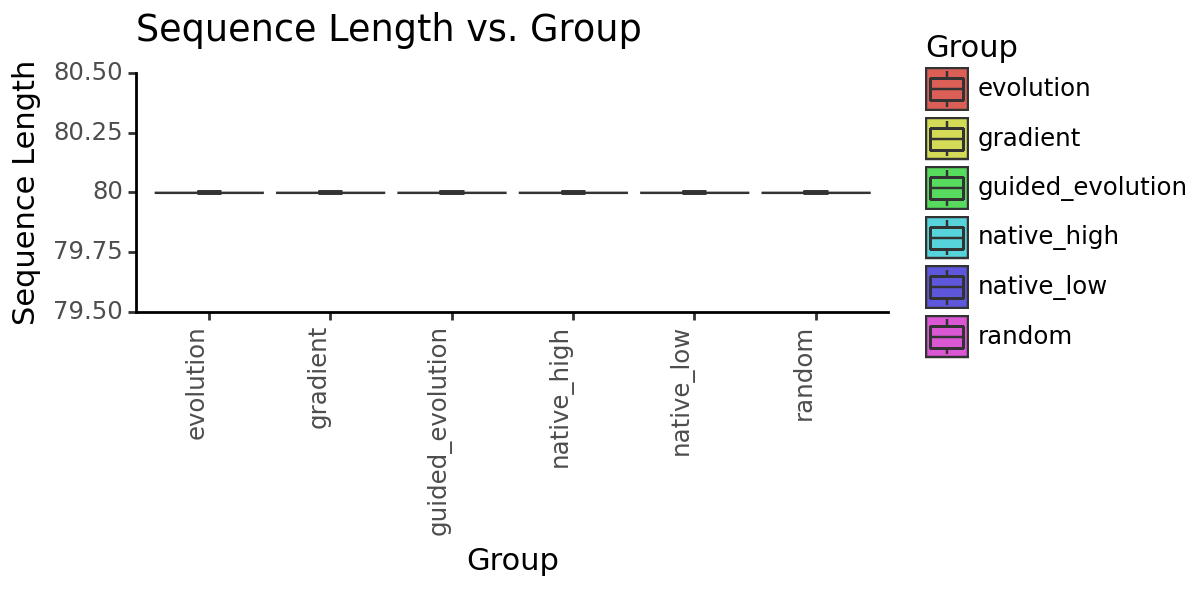

<Figure Size: (600 x 300)>

In [7]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(6,3))

## 1.3 Edit distance (compared to reference)

In [8]:
seqs['edit'] = polygraph.sequence.min_edit_distance_from_reference(seqs, reference_group='native_high')

{'Kruskal': 1.1443090346410912e-07, 'Dunn':                   evolution  gradient  guided_evolution  native_low    random
evolution          1.00e+00  5.44e-01          1.60e-04    4.69e-03  7.74e-01
gradient           5.44e-01  1.00e+00          1.26e-05    4.12e-04  6.91e-01
guided_evolution   1.60e-04  1.26e-05          1.00e+00    4.01e-01  6.73e-05
native_low         4.69e-03  4.12e-04          4.01e-01    1.00e+00  2.12e-03
random             7.74e-01  6.91e-01          6.73e-05    2.12e-03  1.00e+00}


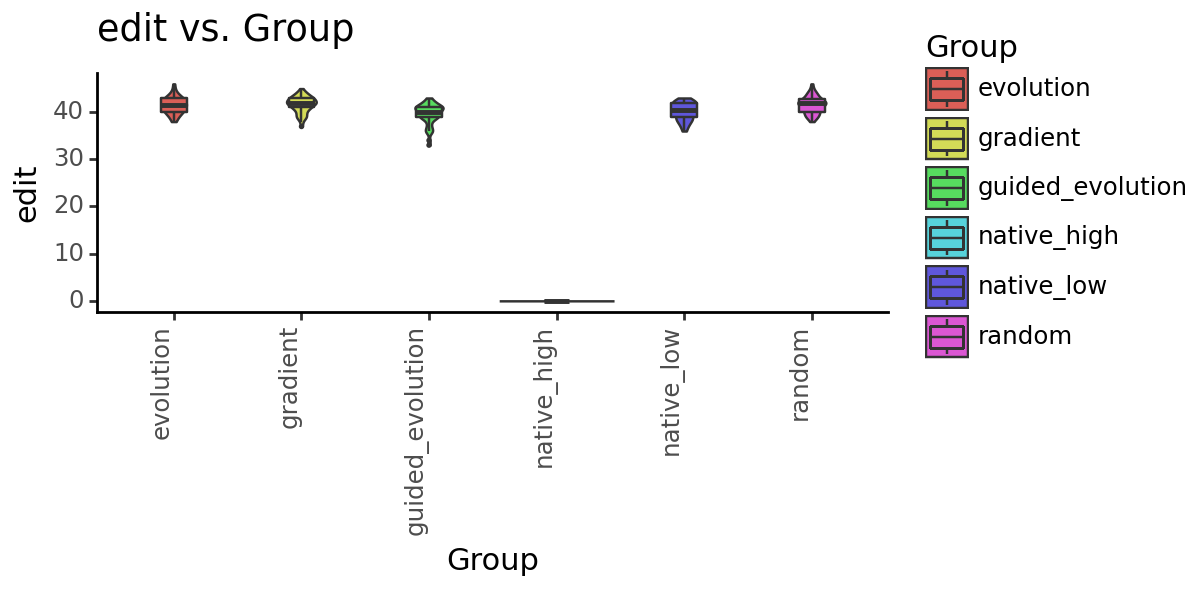

<Figure Size: (600 x 300)>

In [9]:
print(polygraph.stats.kruskal_dunn(seqs[seqs.Group!='native_high'], val_col='edit'))
polygraph.visualize.boxplot(seqs, value_col='edit') + p9.theme(figure_size=(6, 3))

## 1.4 k-mer content

In [10]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs=seqs, k=5, normalize=True)
print(kmers.shape)
kmers.iloc[:5, :5]

(300, 1024)
CPU times: user 670 ms, sys: 23.5 ms, total: 694 ms
Wall time: 690 ms


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA
SeqID,,,,,
seq_0,0.01,0.00,0.0,0.01,0.00
seq_1,0.01,0.01,0.0,0.00,0.00
seq_2,0.01,0.01,0.0,0.00,0.00
seq_3,0.01,0.00,0.0,0.01,0.00
seq_4,0.00,0.00,0.0,0.00,0.01


In [11]:
%%time
emb = polygraph.embedding.embedding_analysis(
    kmers, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.6348119988012597
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 20.1 s, sys: 22.3 s, total: 42.4 s
Wall time: 7.7 s


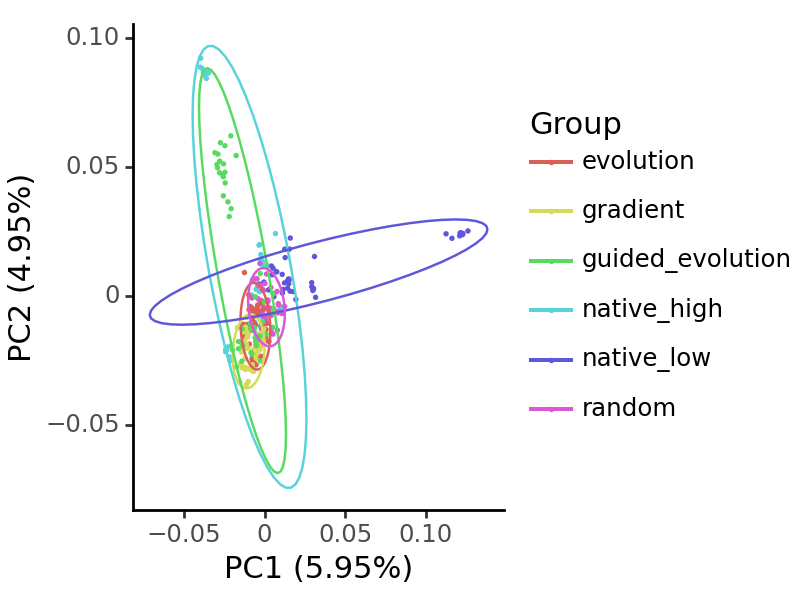

<Figure Size: (400 x 300)>

In [12]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

In [13]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential k-mers compared to reference
native_low    23
gradient      13
random         7
evolution      3
Name: Group, dtype: int64

Top Differential k-mers
           Group  value  score      padj  log2FC
1023    gradient  GCGCG   6.60  4.18e-08    2.80
3069  native_low  TTTTT  -6.20  5.62e-07  -23.47
4092      random  TTTTT  -5.89  4.02e-06   -4.47
1024    gradient  CGCGC   5.76  4.22e-06    2.55
3070  native_low  TTTTC  -5.52  1.71e-05   -5.14


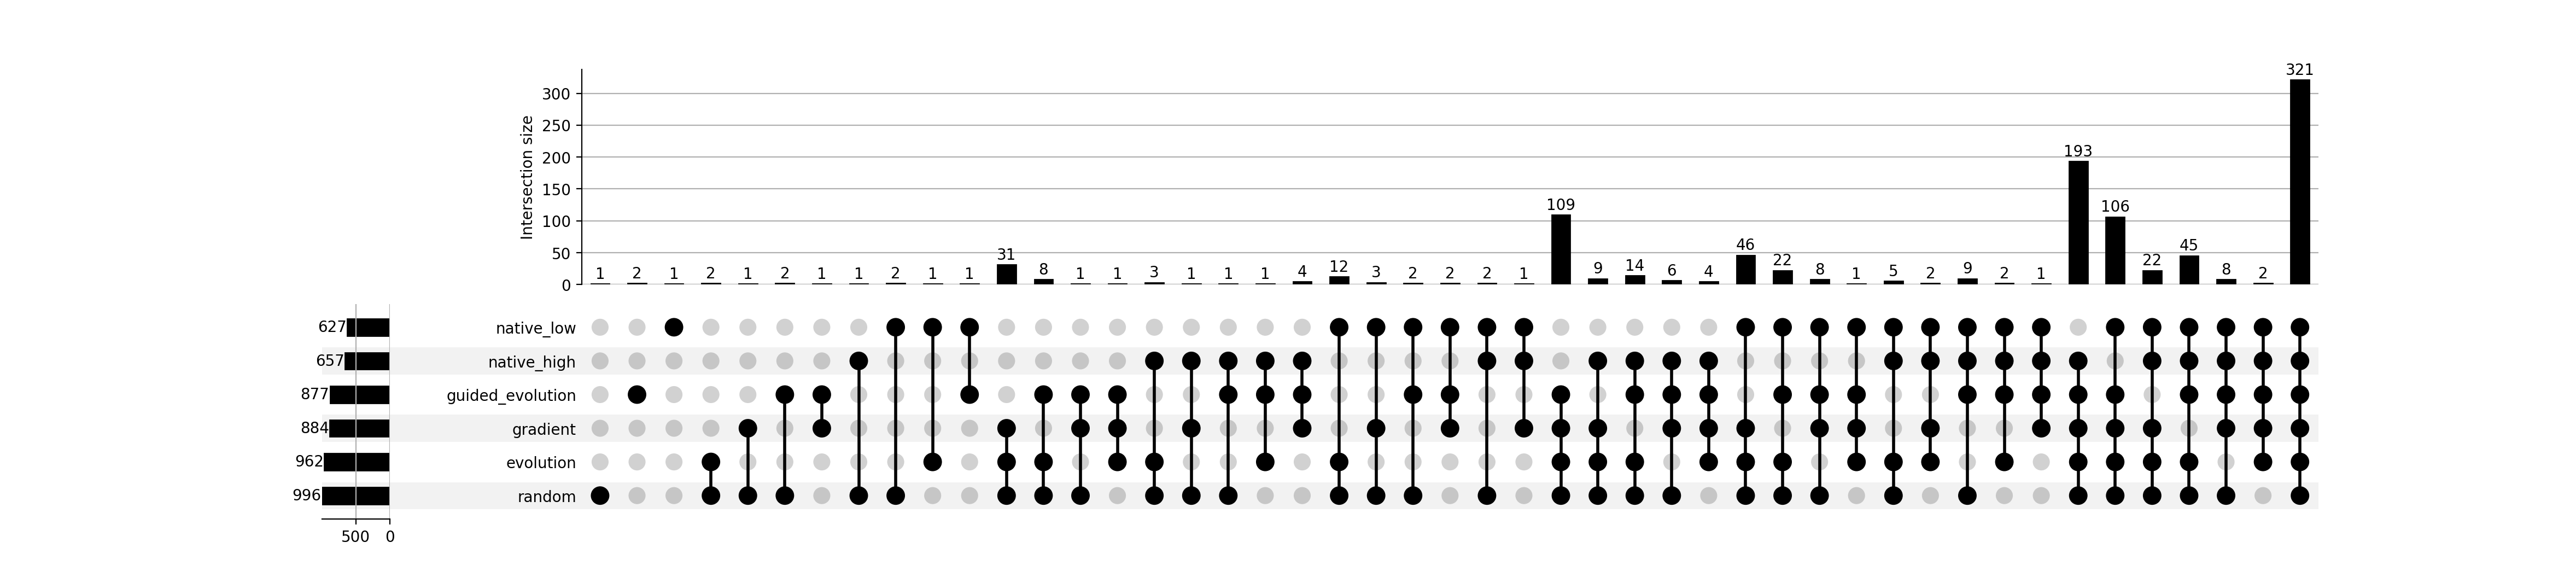

In [14]:
# kmer occurrence
polygraph.visualize.upset_plot(emb)

p-values for proportion of sequences with native nearest neighbor
                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.00      0.96  2.63e-26  1.31e-25
random                  0.10      0.96  6.18e-20  1.03e-19
evolution               0.26      0.96  9.78e-14  1.22e-13
gradient                0.02      0.96  1.24e-24  3.10e-24
guided_evolution        0.26      0.92  8.37e-12  8.37e-12


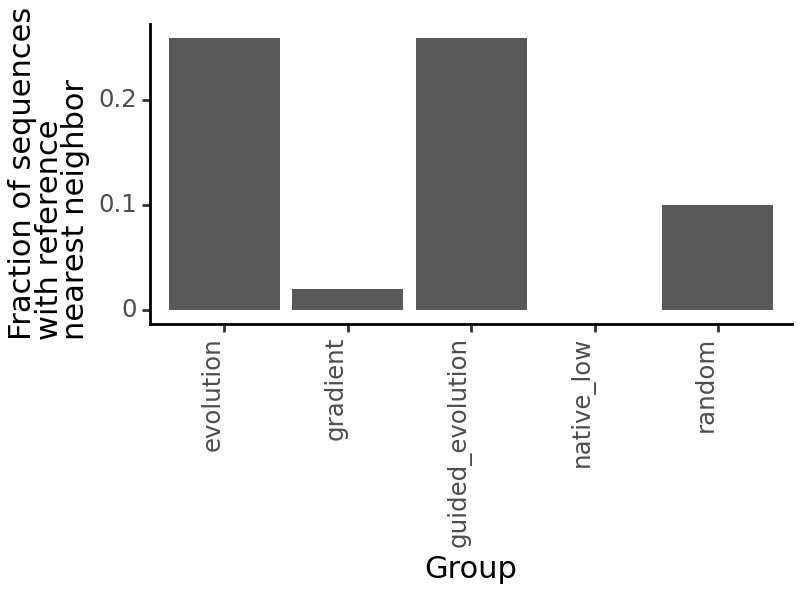

<Figure Size: (400 x 300)>

In [15]:
# 1-NN statistics
print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 1.8780394829766224e-44, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  6.19e-01          3.89e-10     1.21e-16   
gradient           6.19e-01  1.00e+00          7.73e-09     5.99e-15   
guided_evolution   3.89e-10  7.73e-09          1.00e+00     4.90e-02   
native_high        1.21e-16  5.99e-15          4.90e-02     1.00e+00   
native_low         1.98e-04  2.61e-05          1.51e-23     2.20e-33   
random             5.72e-01  3.03e-01          6.47e-12     6.47e-19   

                  native_low    random  
evolution           1.98e-04  5.72e-01  
gradient            2.61e-05  3.03e-01  
guided_evolution    1.51e-23  6.47e-12  
native_high         2.20e-33  6.47e-19  
native_low          1.00e+00  1.87e-03  
random              1.87e-03  1.00e+00  }


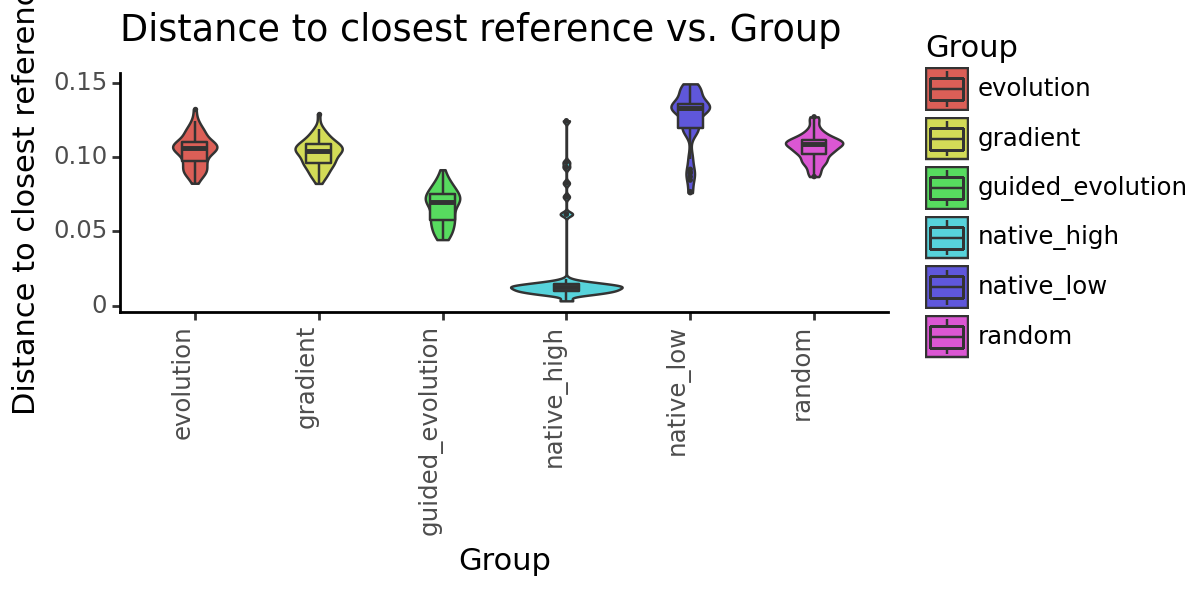

<Figure Size: (600 x 300)>

In [15]:
#Distance to the closest reference sequence
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 8.900023087508012e-24, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  2.73e-10          9.73e-15     4.47e-06   
gradient           2.73e-10  1.00e+00          1.37e-01     1.13e-01   
guided_evolution   9.73e-15  1.37e-01          1.00e+00     1.42e-03   
native_high        4.47e-06  1.13e-01          1.42e-03     1.00e+00   
native_low         2.02e-14  1.78e-01          8.61e-01     2.37e-03   
random             2.31e-01  3.95e-07          3.91e-11     8.50e-04   

                  native_low    random  
evolution           2.02e-14  2.31e-01  
gradient            1.78e-01  3.95e-07  
guided_evolution    8.61e-01  3.91e-11  
native_high         2.37e-03  8.50e-04  
native_low          1.00e+00  9.82e-11  
random              9.82e-11  1.00e+00  }


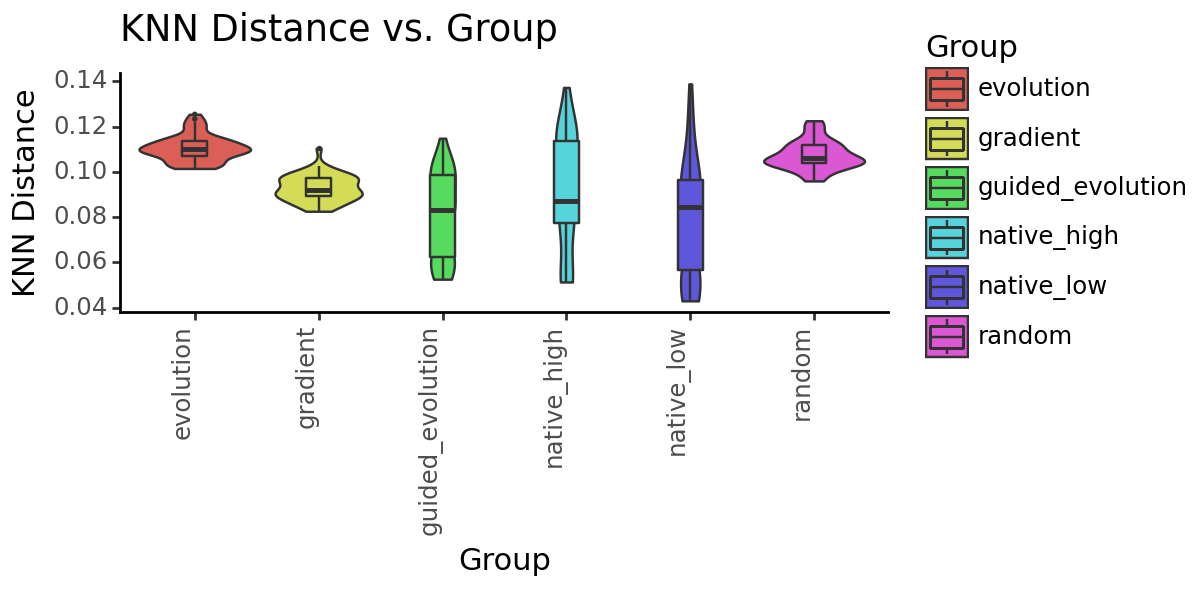

<Figure Size: (600 x 300)>

In [16]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [17]:
# Performance of a classifier trained to separate each group from the reference
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,0.99,0.99
random,0.99,0.99
evolution,0.97,0.97
gradient,0.99,0.99
guided_evolution,0.88,0.88


## 1.5 All-to-all comparisons

The above analyses compare each group of synthetic sequences to the reference group (native_high) one at a time. We may also want to understand how similar these groups are to each other. Below are some all-to-all comparisons.

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


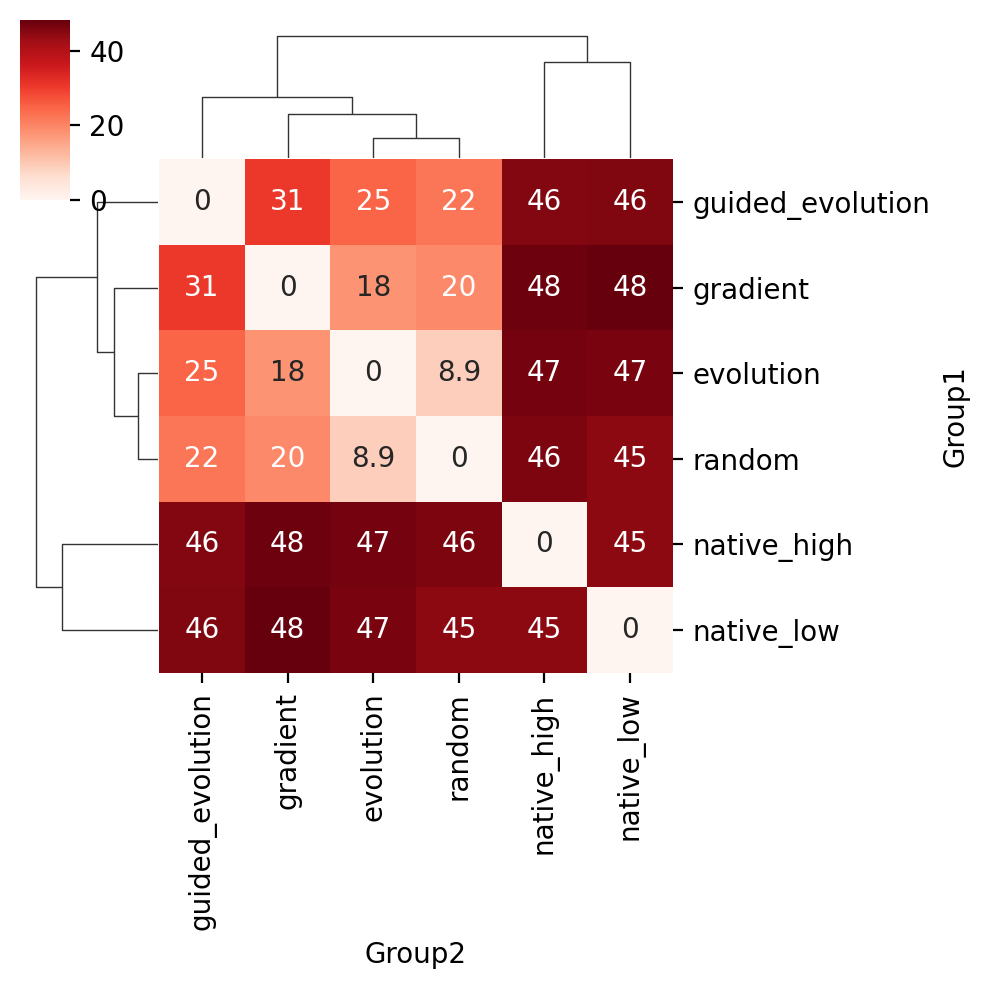

In [18]:
# Average Edit distance
mean_edit = polygraph.sequence.groupwise_mean_edit_dist(seqs)
sns.clustermap(mean_edit, annot=True, cmap="Reds", figsize=(5,5))

In [19]:
# All-to-all 1-NN statistics
emb = polygraph.embedding.joint_1nn(emb, reference_group="native_high", use_pca=True)
emb.uns['1NN_group_probs'].style.background_gradient("Blues")

one_nn_group,evolution,gradient,guided_evolution,native_high,native_low,random
Group,,,,,,
evolution,0.000000,0.040000,0.000000,0.000000,0.000000,0.960000
gradient,0.800000,0.100000,0.000000,0.000000,0.000000,0.100000
guided_evolution,0.000000,0.000000,0.740000,0.260000,0.000000,0.000000
native_high,0.000000,0.000000,0.060000,0.920000,0.020000,0.000000
native_low,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
random,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 1.6 Gapped k-mer embedding

In [20]:
gkm = polygraph.sequence.fastsk(seqs, k=5, m=1)

Length of shortest train sequence: 80
Length of shortest test sequence: 80
Dictionary size = 4 (+1 for unknown char).
g = 5, k = 4, 45600 features
Initializing kernel function


In [21]:
%%time
emb = polygraph.embedding.embedding_analysis(
    gkm, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9714570617894056
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


CPU times: user 15.2 s, sys: 25.4 s, total: 40.6 s
Wall time: 1.82 s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


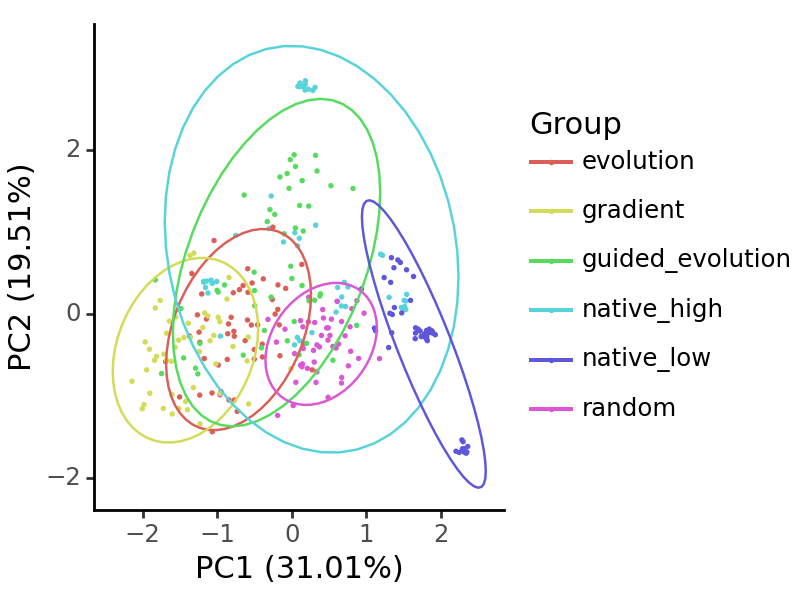

<Figure Size: (400 x 300)>

In [22]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

In [23]:
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,1.00,1.00
random,1.00,1.00
evolution,1.00,1.00
gradient,1.00,1.00
guided_evolution,0.98,0.98


# 2. Model based evaluation

In [22]:
# Download yeast sequence-to-promoter activity model
!wget https://zenodo.org/records/10214625/files/yeast-model.pth

--2024-01-30 19:15:34--  https://zenodo.org/records/10214625/files/yeast-model.pth
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9968513 (9.5M) [application/octet-stream]
Saving to: ‘yeast-model.pth.1’

yeast-model.pth.1   100%[===================>]   9.51M  6.27MB/s    in 1.5s    

2024-01-30 19:15:37 (6.27 MB/s) - ‘yeast-model.pth.1’ saved [9968513/9968513]



In [24]:
import torch
model = torch.load('yeast-model.pth')

## 2.1 Predictions

In [25]:
seqs[['complex_pred', 'defined_pred']] = polygraph.models.predict(seqs, model, batch_size=512, device=0)

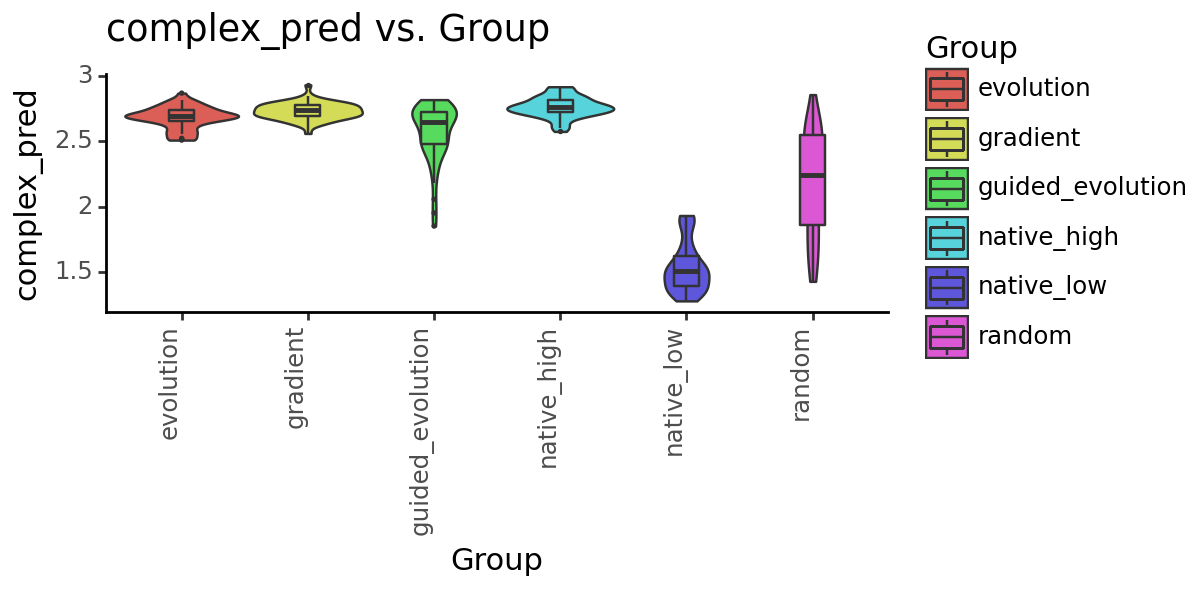

<Figure Size: (600 x 300)>

In [26]:
polygraph.visualize.boxplot(seqs, value_col='complex_pred') + p9.theme(figure_size=(6, 3))

## 2.2 cell type specificity

In [27]:
seqs = polygraph.models.cell_type_specificity(seqs, 'complex_pred', ['defined_pred'])

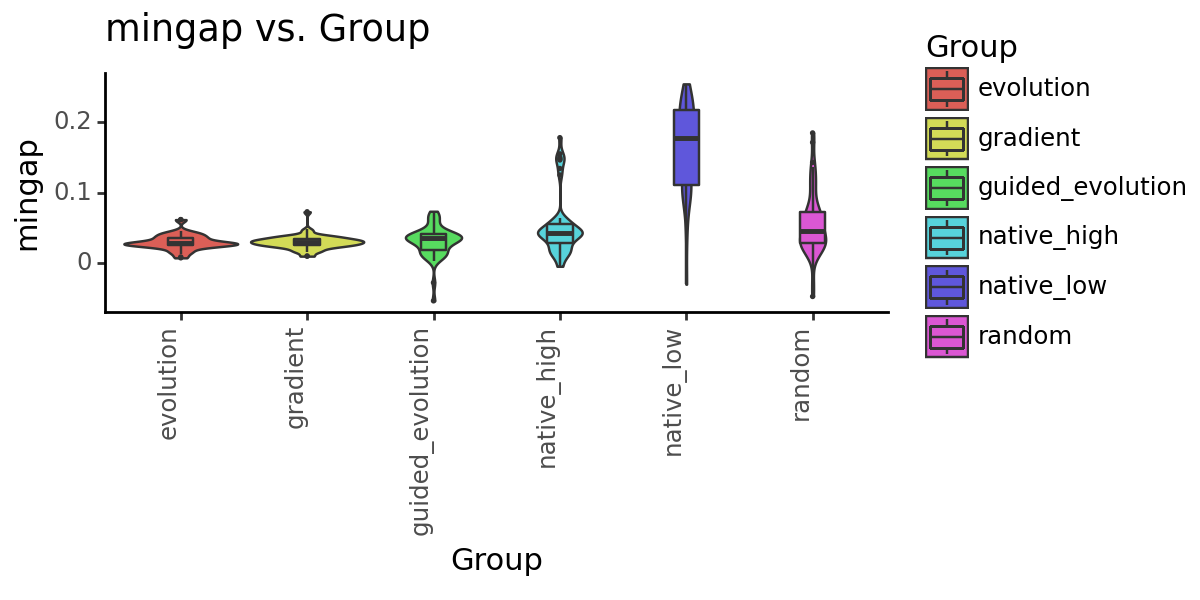

<Figure Size: (600 x 300)>

In [28]:
polygraph.visualize.boxplot(seqs, value_col='mingap') + p9.theme(figure_size=(6, 3))

## 2.3 Model embeddings

In [29]:
%%time
emb = polygraph.models.get_embeddings(seqs, model, batch_size=512, drop_last_layers=4, device=0)
emb.shape

CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 12 ms


(300, 512)

In [30]:
emb = polygraph.embedding.embedding_analysis(emb, seqs=seqs, reference_group='native_high', max_iter=5000, use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9946259
UMAP


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


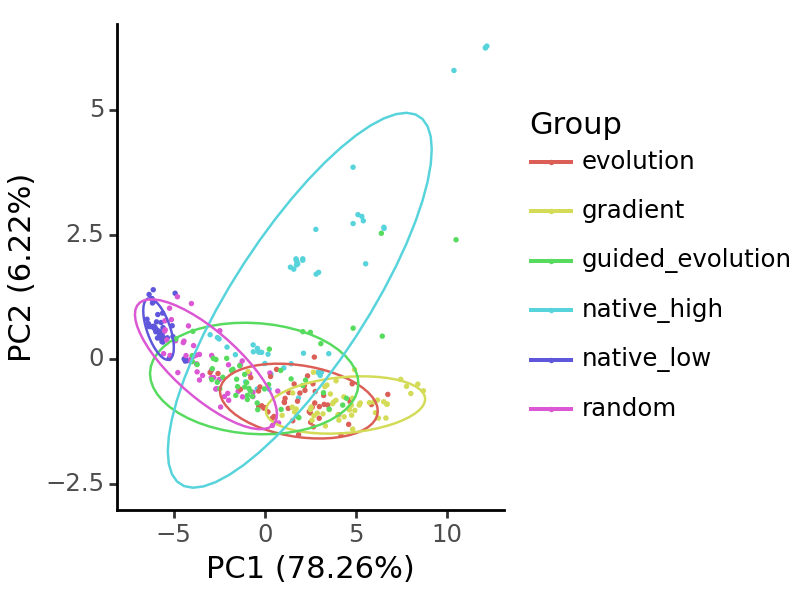

<Figure Size: (400 x 300)>

In [31]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4, 3))

                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.00      1.00  1.98e-29  9.91e-29
random                  0.02      0.92  2.73e-22  4.55e-22
evolution               0.04      0.90  6.18e-20  7.72e-20
gradient                0.02      0.92  2.73e-22  4.55e-22
guided_evolution        0.16      0.88  1.88e-13  1.88e-13


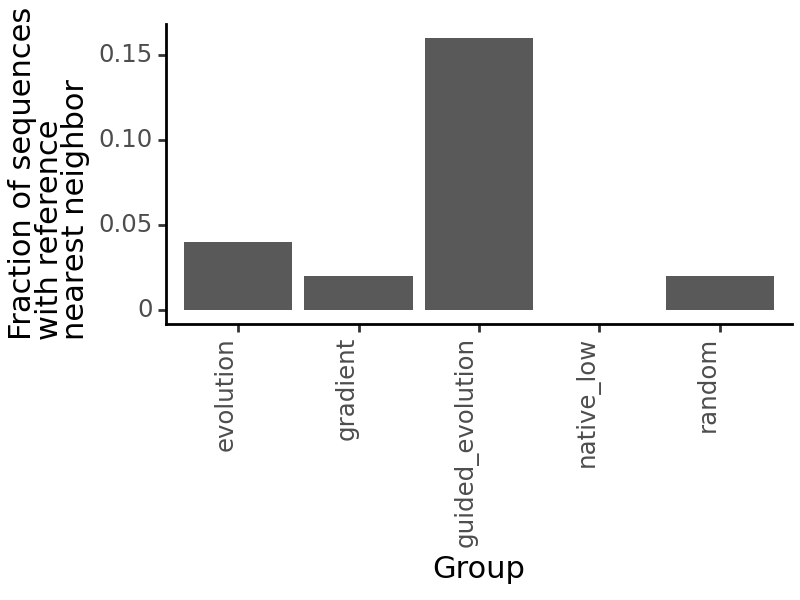

<Figure Size: (400 x 300)>

In [32]:
# 1-NN statistics
print(emb.uns["1NN_ref_prop_test"])
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

{'Kruskal': 1.8801825377028785e-36, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  6.13e-05          7.64e-01     3.47e-06   
gradient           6.13e-05  1.00e+00          1.94e-04     4.34e-18   
guided_evolution   7.64e-01  1.94e-04          1.00e+00     8.58e-07   
native_high        3.47e-06  4.34e-18          8.58e-07     1.00e+00   
native_low         5.91e-14  4.49e-04          4.45e-13     1.32e-34   
random             6.22e-02  3.48e-02          1.11e-01     6.40e-11   

                  native_low    random  
evolution           5.91e-14  6.22e-02  
gradient            4.49e-04  3.48e-02  
guided_evolution    4.45e-13  1.11e-01  
native_high         1.32e-34  6.40e-11  
native_low          1.00e+00  1.76e-08  
random              1.76e-08  1.00e+00  }


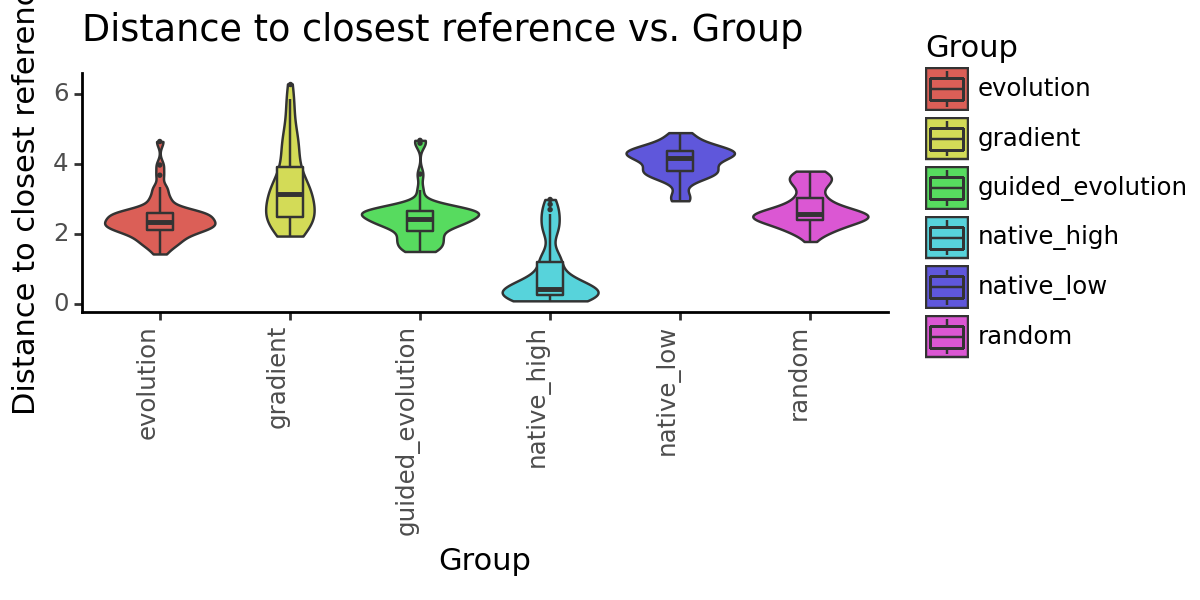

<Figure Size: (600 x 300)>

In [33]:
#Distance to reference
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

{'Kruskal': 6.69107587927871e-28, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  1.03e-01          2.63e-02     1.85e-04   
gradient           1.03e-01  1.00e+00          8.50e-05     6.30e-08   
guided_evolution   2.63e-02  8.50e-05          1.00e+00     1.47e-01   
native_high        1.85e-04  6.30e-08          1.47e-01     1.00e+00   
native_low         5.06e-11  1.01e-06          4.47e-19     2.11e-25   
random             6.58e-01  2.09e-01          8.08e-03     3.53e-05   

                  native_low    random  
evolution           5.06e-11  6.58e-01  
gradient            1.01e-06  2.09e-01  
guided_evolution    4.47e-19  8.08e-03  
native_high         2.11e-25  3.53e-05  
native_low          1.00e+00  7.46e-10  
random              7.46e-10  1.00e+00  }


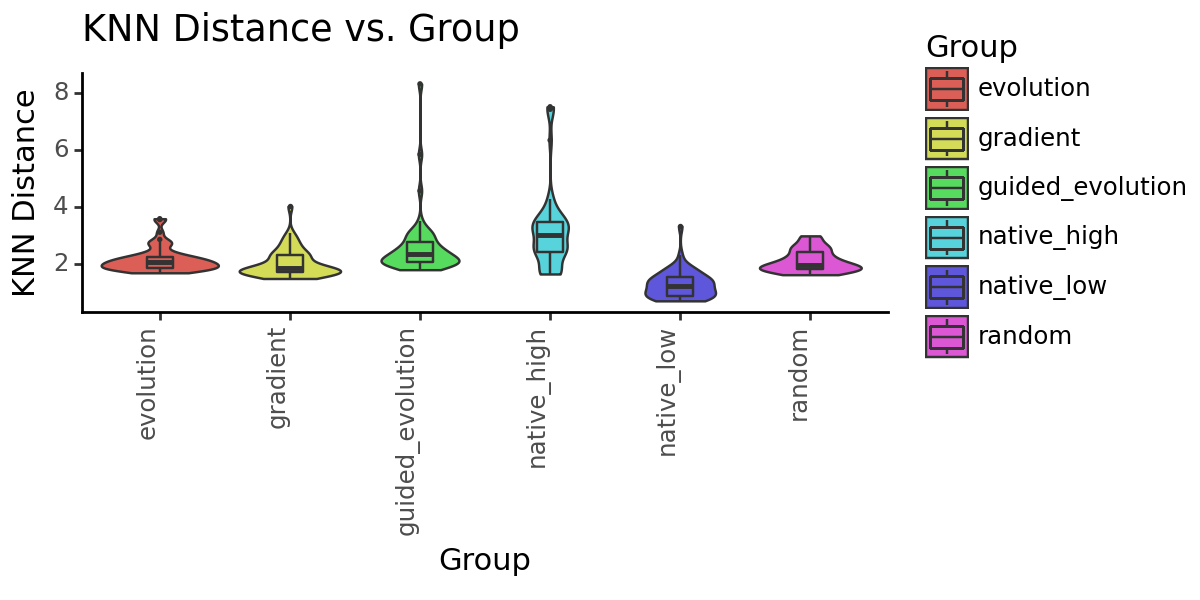

<Figure Size: (600 x 300)>

In [34]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [35]:
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,1.0,1.0
random,1.0,1.0
evolution,1.0,1.0
gradient,1.0,1.0
guided_evolution,1.0,1.0


# 3. Evaluate motif content

In [35]:
meme_file = polygraph.input.download_jaspar("fungi")

--2024-01-30 19:15:45--  https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.48.179, 2001:700:2:8200::26fc
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.48.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79182 (77K) [text/plain]
Saving to: ‘/usr/local/lib/python3.8/dist-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt.5’

     0K .......... .......... .......... .......... .......... 64%  153K 0s
    50K .......... .......... .......                         100%  246M=0.3s

2024-01-30 19:15:48 (236 KB/s) - ‘/usr/local/lib/python3.8/dist-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt.5’ saved [79182/79182]



In [36]:
%%time
sites = polygraph.motifs.scan(seqs, '/usr/local/lib/python3.8/dist-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt')
sites.head()

Read 178 motifs from file.
CPU times: user 2.5 s, sys: 3.27 ms, total: 2.5 s
Wall time: 2.5 s


,MotifID,SeqID,start,end,strand,Group
0,ARG80,seq_242,6,11,+,gradient
93,ARR1,seq_242,61,68,+,gradient
199,ASH1,seq_242,13,4,-,gradient
571,DAL81,seq_242,12,30,+,gradient
628,DAL82,seq_242,31,23,-,gradient


## 3.1 Motif count embedding

In [37]:
counts = polygraph.motifs.motif_frequencies(sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ABF1,ABF2,ACE2,ADR1,AFT1
SeqID,,,,,
seq_0,0.03,0.0,0.0,0.00,0.0
seq_1,0.00,0.0,0.0,0.00,0.0
seq_2,0.00,0.0,0.0,0.01,0.0
seq_3,0.03,0.0,0.0,0.00,0.0
seq_4,0.00,0.0,0.0,0.00,0.0


In [38]:
%%time
emb = polygraph.embedding.embedding_analysis(
    counts, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.8876453606343614
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 13.9 s, sys: 18.9 s, total: 32.8 s
Wall time: 1.31 s


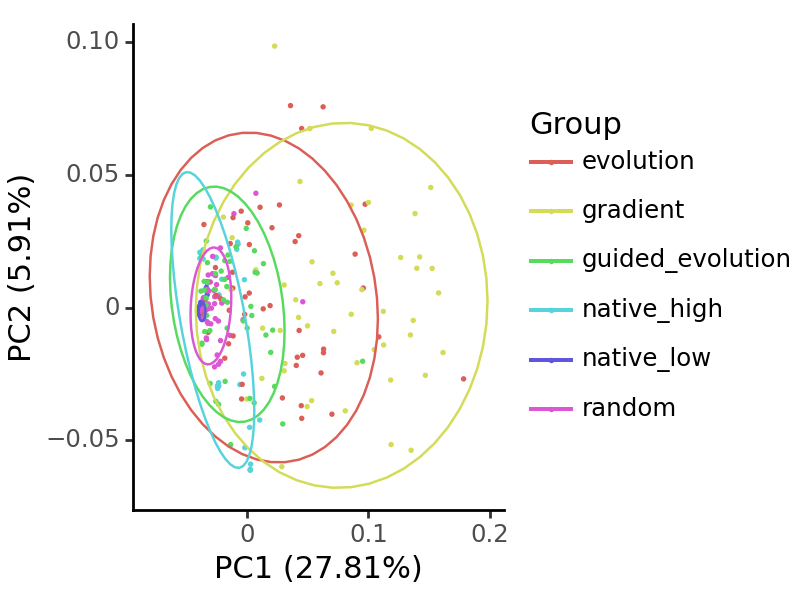

<Figure Size: (400 x 300)>

In [39]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4,3))

In [40]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential motifs compared to reference
gradient      31
evolution     13
native_low    13
random         3
Name: Group, dtype: int64

Top Differential motifs
        Group  value  score      padj  log2FC
175  gradient  RSC30   7.65  3.46e-12    4.57
176  gradient   RSC3   6.94  3.55e-10    3.18
177  gradient   MBP1   6.55  3.38e-09    3.82
178  gradient   SUT1   6.24  1.89e-08    3.63
179  gradient  DAL81   5.93  1.05e-07    6.06


Fraction of sequences by 1-NN group
                  group_prop  ref_prop
Group                                 
native_low              0.00      0.94
random                  0.04      0.92
evolution               0.32      0.96
gradient                0.20      0.98
guided_evolution        0.58      0.94

p-values for proportion of sequences with native nearest neighbor
                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.00      0.94  4.64e-25  2.32e-24
random                  0.04      0.92  6.07e-21  1.52e-20
evolution               0.32      0.96  6.22e-12  7.77e-12
gradient                0.20      0.98  5.13e-17  8.55e-17
guided_evolution        0.58      0.94  3.59e-05  3.59e-05


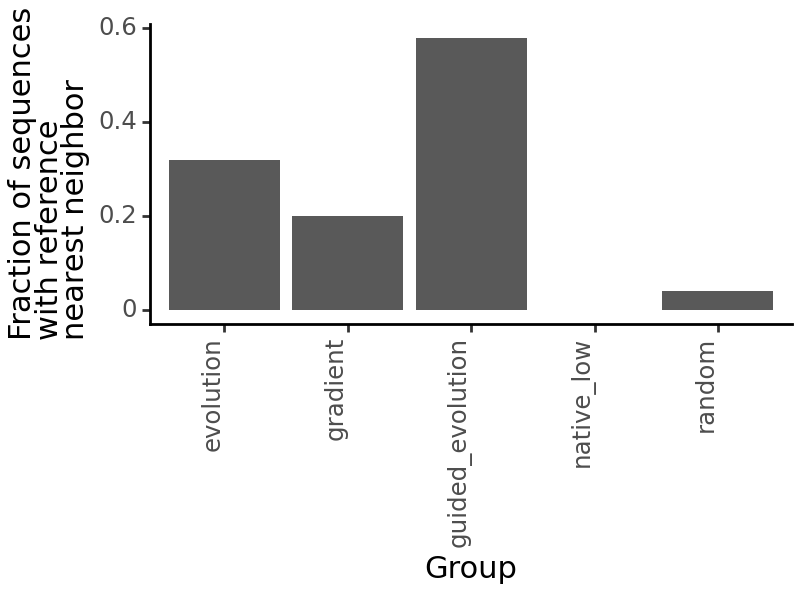

<Figure Size: (400 x 300)>

In [41]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 1.130206265030664e-43, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  3.88e-03          8.41e-04     1.64e-22   
gradient           3.88e-03  1.00e+00          3.73e-10     7.00e-37   
guided_evolution   8.41e-04  3.73e-10          1.00e+00     1.82e-10   
native_high        1.64e-22  7.00e-37          1.82e-10     1.00e+00   
native_low         8.03e-11  4.15e-21          1.64e-03     1.31e-03   
random             1.45e-04  2.64e-11          6.35e-01     2.89e-09   

                  native_low    random  
evolution           8.03e-11  1.45e-04  
gradient            4.15e-21  2.64e-11  
guided_evolution    1.64e-03  6.35e-01  
native_high         1.31e-03  2.89e-09  
native_low          1.00e+00  6.60e-03  
random              6.60e-03  1.00e+00  }


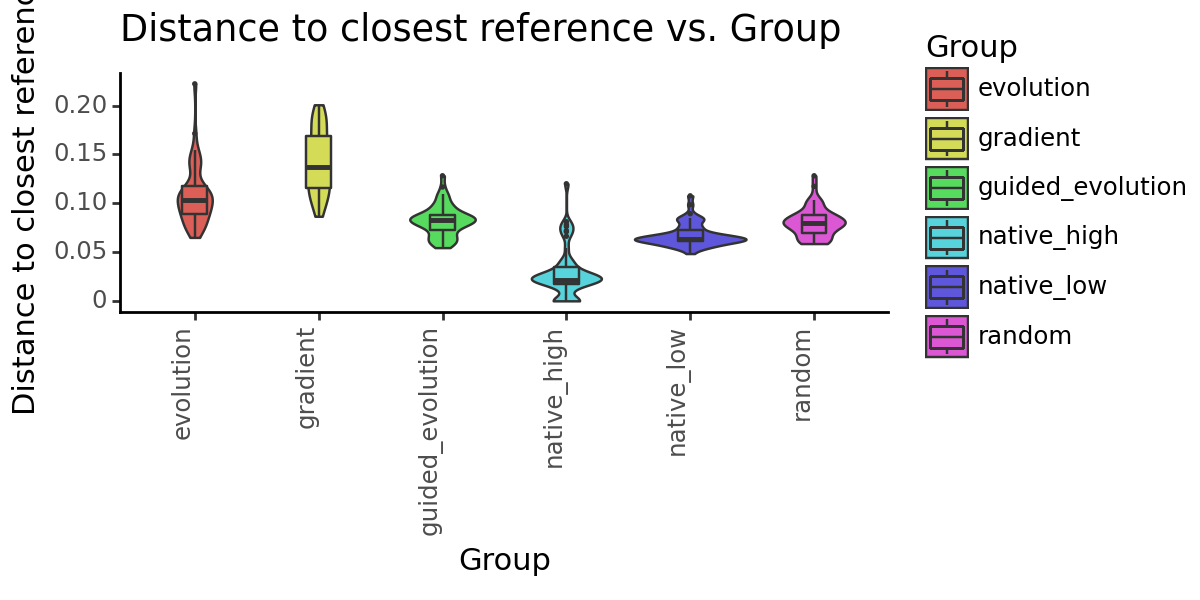

<Figure Size: (600 x 300)>

In [42]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 9.231002304295897e-49, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  1.55e-02          6.96e-03     1.16e-12   
gradient           1.55e-02  1.00e+00          3.92e-07     1.81e-21   
guided_evolution   6.96e-03  3.92e-07          1.00e+00     1.19e-05   
native_high        1.16e-12  1.81e-21          1.19e-05     1.00e+00   
native_low         7.18e-25  4.26e-37          2.88e-14     1.42e-03   
random             3.13e-10  3.15e-18          3.39e-04     4.08e-01   

                  native_low    random  
evolution           7.18e-25  3.13e-10  
gradient            4.26e-37  3.15e-18  
guided_evolution    2.88e-14  3.39e-04  
native_high         1.42e-03  4.08e-01  
native_low          1.00e+00  6.73e-05  
random              6.73e-05  1.00e+00  }


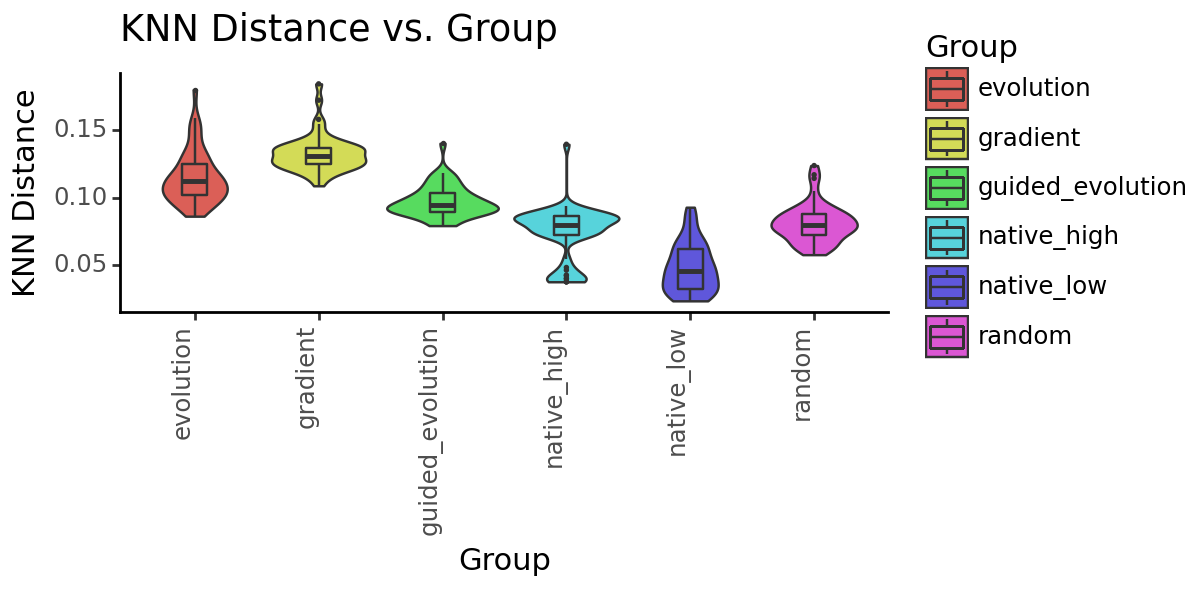

<Figure Size: (600 x 300)>

In [43]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [44]:
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,0.99,0.99
random,0.93,0.93
evolution,0.85,0.85
gradient,0.97,0.97
guided_evolution,0.83,0.83


## 3.2 motif combinations

In [45]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(
    counts, seqs, reference_group='native_high', min_group_freq=15)

Listing motif combinations
Making count matrix
Filtering
Selected 1534 combinations
Significance testing
CPU times: user 4.57 s, sys: 975 µs, total: 4.57 s
Wall time: 4.57 s


In [46]:
motif_combinations.sort_values('padj').head()

,Group,group_prop,ref_prop,pval,padj,combination
3,gradient,0.86,0.02,2.03e-19,3.58e-16,"(RSC30, RSC3)"
23,gradient,0.78,0.00,8.29e-18,7.31e-15,"(MBP1, RSC3)"
8,gradient,0.80,0.02,5.13e-17,3.02e-14,"(RSC30, TEA1)"
18,gradient,0.78,0.02,2.73e-16,1.21e-13,"(SUT1, RSC30)"
48,gradient,0.70,0.00,4.11e-15,1.21e-12,"(MBP1, TEA1)"


In [47]:
# Are there any significant motif combinations where neither individual motif is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .01].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .01]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [48]:
sig_combs.Group.value_counts()

native_low          10
gradient             8
random               8
evolution            8
guided_evolution     3
Name: Group, dtype: int64

## 3.3 motif positions

In [52]:
# Select the TF motif most enriched in synthetic sequences
df = emb.uns['DE_test']
df[df.padj < .05].Group.value_counts()

gradient      31
evolution     13
native_low    13
random         3
Name: Group, dtype: int64

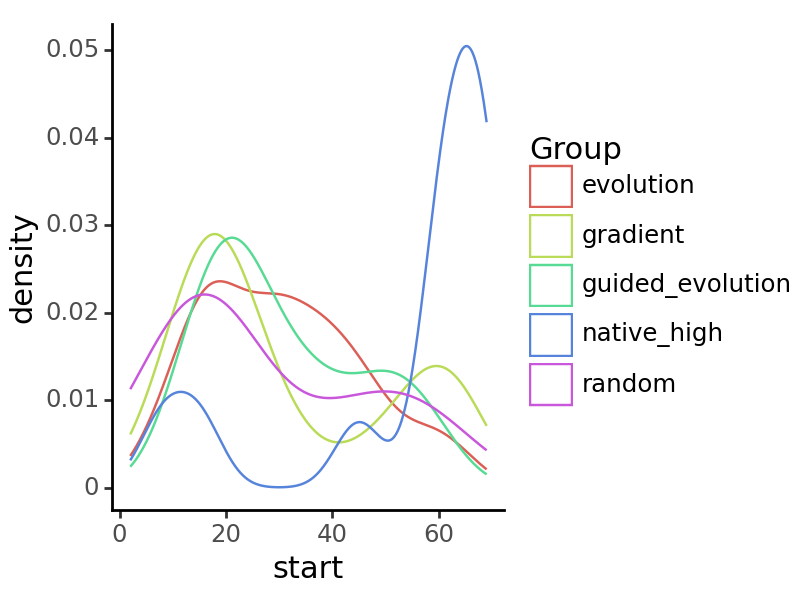

<Figure Size: (400 x 300)>

In [50]:
polygraph.visualize.densityplot(sites[sites.MotifID=='RSC30'], value_col='start') + p9.theme(figure_size=(4,3))

In [51]:
polygraph.stats.kruskal_dunn(sites[sites.MotifID=='RSC30'], val_col='start')

{'Kruskal': 0.00642637465639194,
 'Dunn':                   evolution  gradient  guided_evolution  native_high    random
 evolution          1.00e+00  5.79e-01          8.88e-01     5.41e-03  5.79e-01
 gradient           5.79e-01  1.00e+00          5.79e-01     2.66e-03  5.79e-01
 guided_evolution   8.88e-01  5.79e-01          1.00e+00     8.42e-03  5.79e-01
 native_high        5.41e-03  2.66e-03          8.42e-03     1.00e+00  7.68e-03
 random             5.79e-01  5.79e-01          5.79e-01     7.68e-03  1.00e+00}

## 3.4 NMF

In [53]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native_high', n_components=10)

CPU times: user 1.78 s, sys: 5.13 s, total: 6.91 s
Wall time: 110 ms


In [54]:
p[p.padj < .05].Group.value_counts()

evolution           8
gradient            8
random              7
native_low          5
guided_evolution    4
Name: Group, dtype: int64

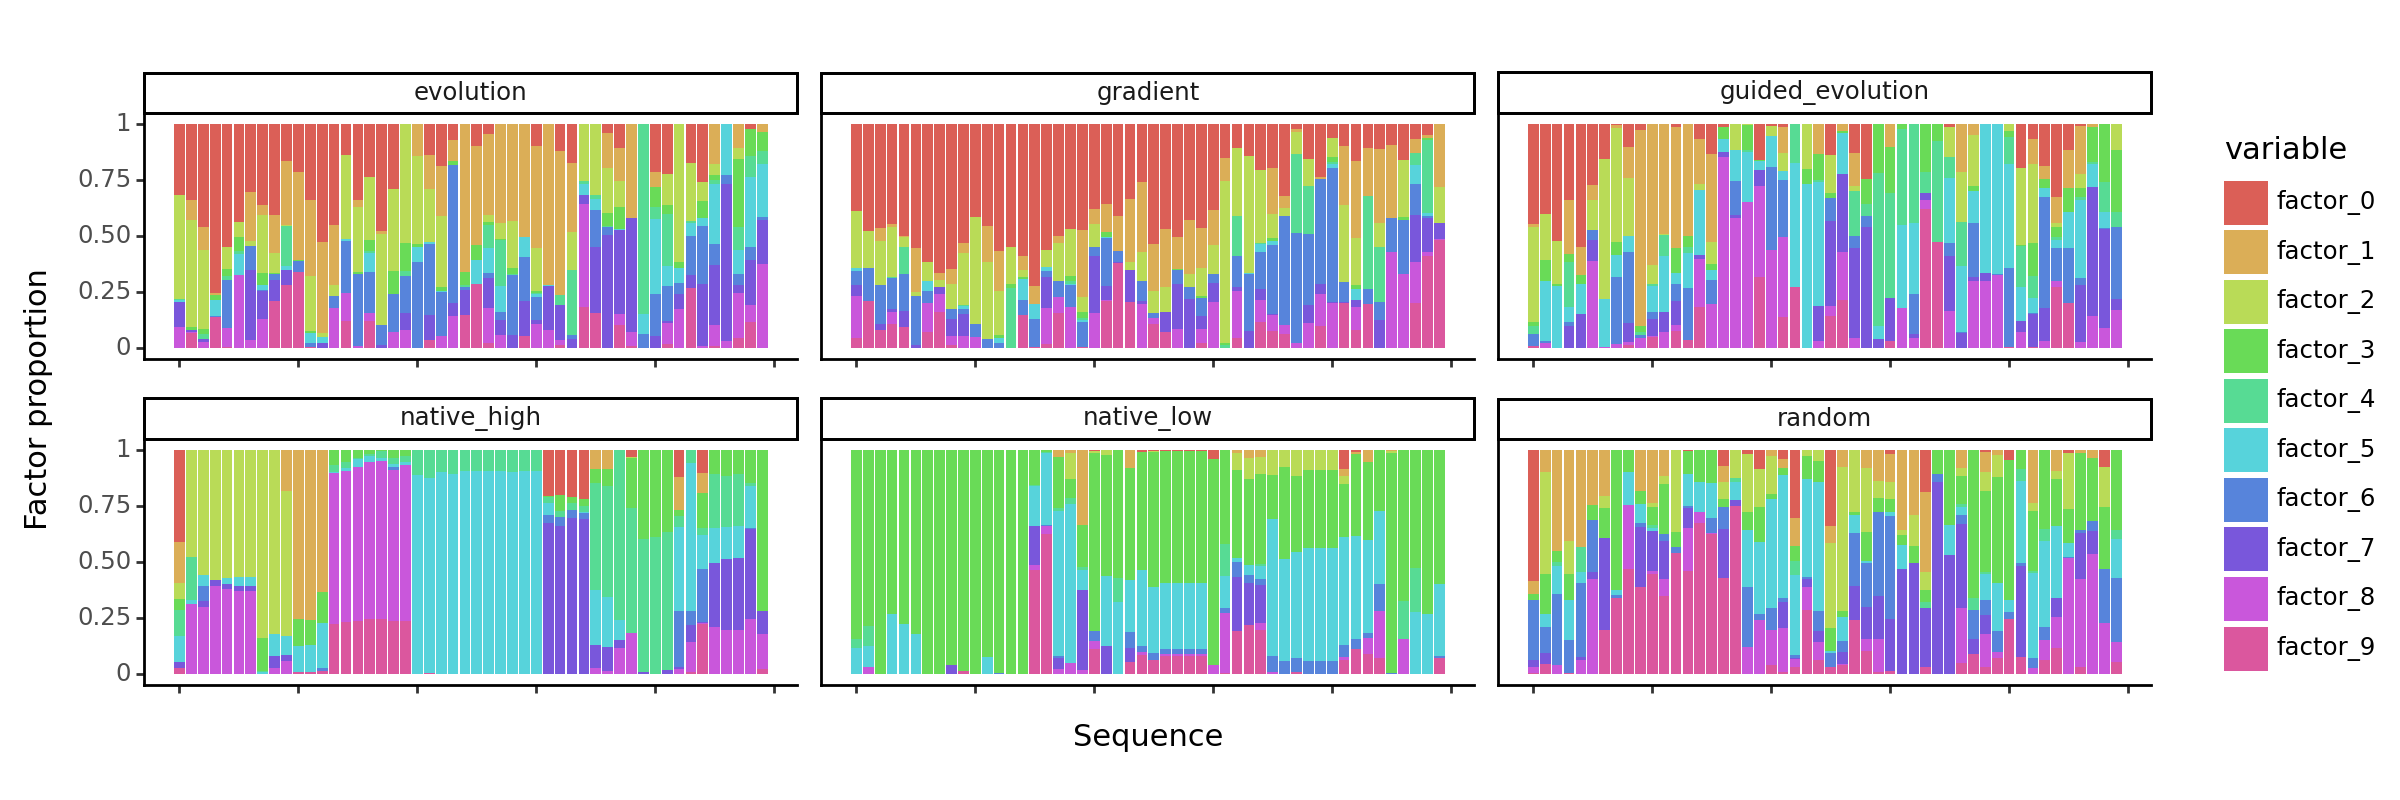

<Figure Size: (1200 x 400)>

In [55]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

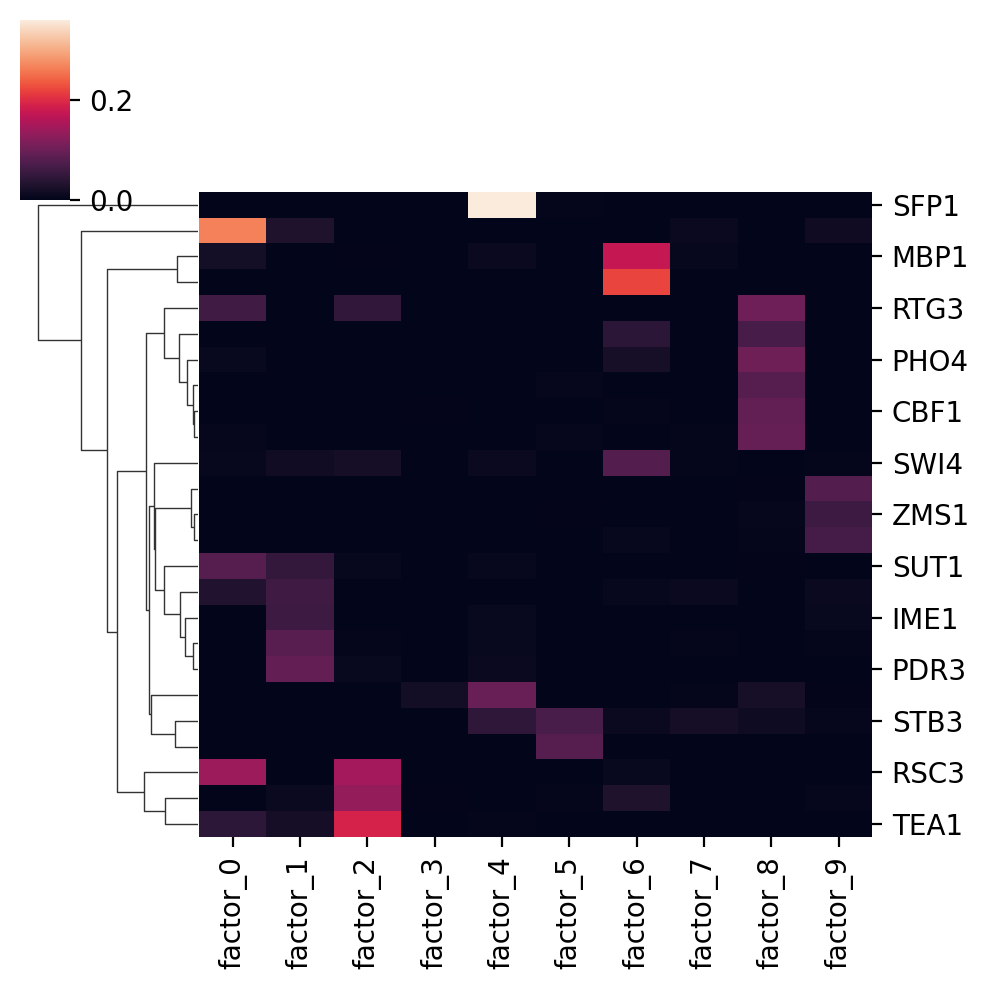

In [56]:
polygraph.visualize.plot_factors_nmf(H, n_features=25, figsize=(5,5))

## 3.5 Filter motifs by ISM

In [57]:
ism = polygraph.models.ism_score(model, seqs, batch_size=512, device=0)
ism.shape

(300, 80)

In [58]:
# Score each motif site by its average ISM score
sites = polygraph.motifs.score_sites(sites, seqs, ism)
sites.head()

,MotifID,SeqID,start,end,strand,Group,score
0,ARG80,seq_242,6,11,+,gradient,9.36e-03
93,ARR1,seq_242,61,68,+,gradient,3.89e-03
199,ASH1,seq_242,13,4,-,gradient,8.03e-03
571,DAL81,seq_242,12,30,+,gradient,6.68e-03
628,DAL82,seq_242,31,23,-,gradient,7.50e-03


In [59]:
# Select the top 50 motifs
top_motifs = sites.groupby('MotifID').score.max().sort_values(ascending=False).head(50).index.tolist()
top_motifs[:5]

['ASG1', 'ECM22', 'YER184C', 'SIP4', 'PUT3']

In [60]:
top_motif_sites = sites[sites.MotifID.isin(top_motifs)]

In [61]:
counts = polygraph.motifs.motif_frequencies(top_motif_sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ABF1,ACE2,ADR1,ASG1,CAT8
SeqID,,,,,
seq_0,0.03,0.0,0.00,0.0,0.0
seq_1,0.00,0.0,0.00,0.0,0.0
seq_2,0.00,0.0,0.01,0.0,0.0
seq_3,0.03,0.0,0.00,0.0,0.0
seq_4,0.00,0.0,0.00,0.0,0.0


In [62]:
emb = polygraph.embedding.embedding_analysis(
    counts, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  1.0
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


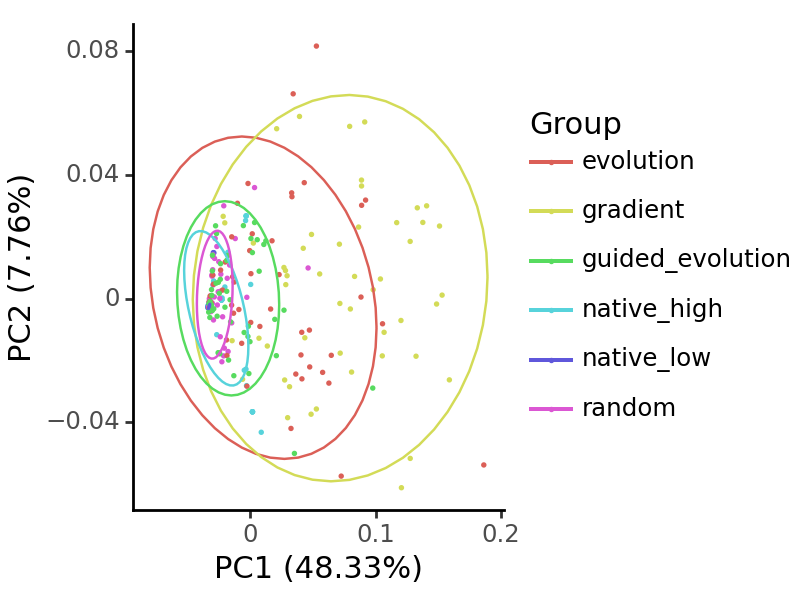

<Figure Size: (400 x 300)>

In [63]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 8.222975311037462e-47, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  2.71e-03          5.05e-03     3.26e-21   
gradient           2.71e-03  1.00e+00          7.09e-09     1.05e-35   
guided_evolution   5.05e-03  7.09e-09          1.00e+00     3.19e-11   
native_high        3.26e-21  1.05e-35          3.19e-11     1.00e+00   
native_low         8.98e-15  3.39e-27          6.65e-07     9.51e-02   
random             1.26e-04  9.19e-12          2.89e-01     2.10e-08   

                  native_low    random  
evolution           8.98e-15  1.26e-04  
gradient            3.39e-27  9.19e-12  
guided_evolution    6.65e-07  2.89e-01  
native_high         9.51e-02  2.10e-08  
native_low          1.00e+00  9.11e-05  
random              9.11e-05  1.00e+00  }


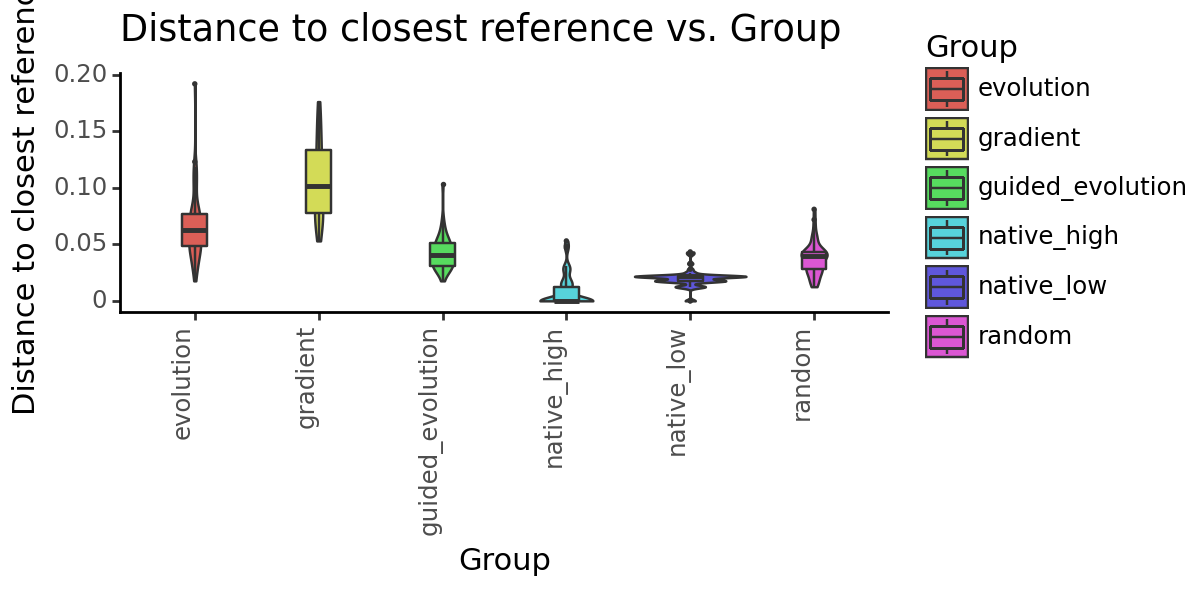

<Figure Size: (600 x 300)>

In [64]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

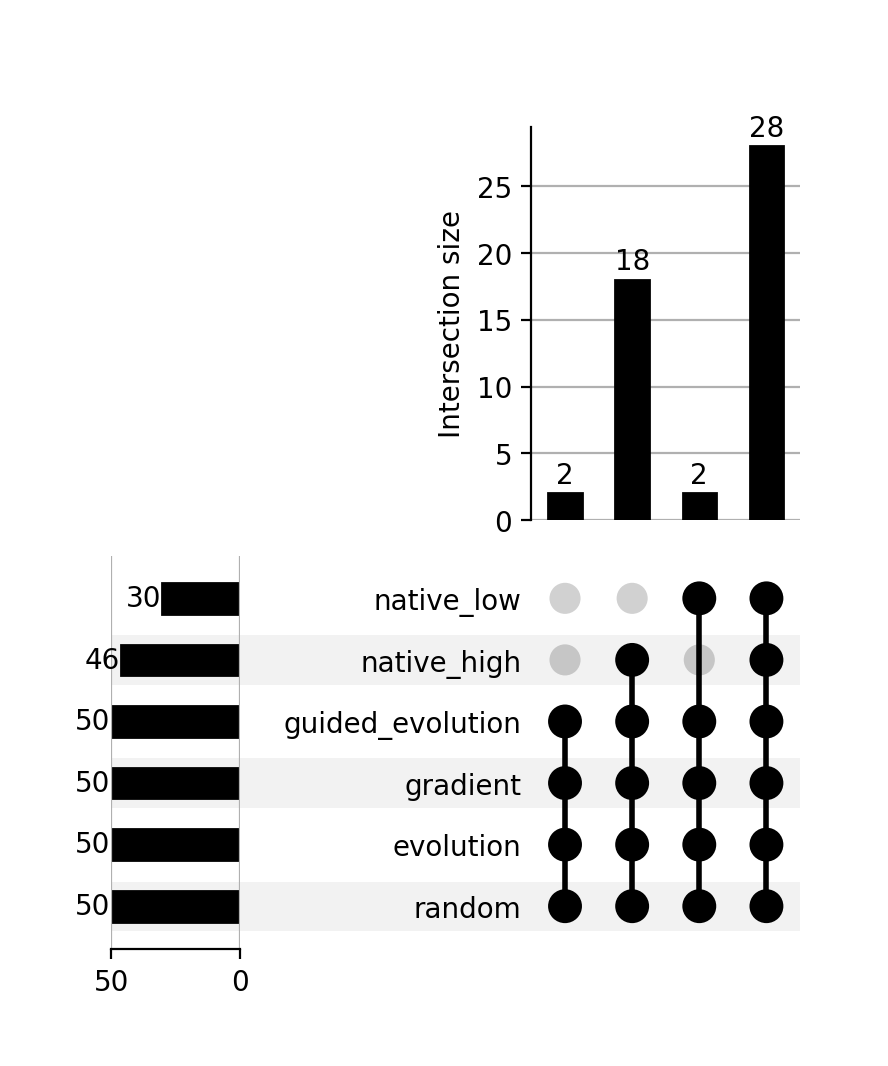

In [65]:
# Motif occurrence
polygraph.visualize.upset_plot(emb)